In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['PROJ_LIB'] = '/home/jhemedinger/anaconda3/envs/cmac_env/share/proj/'
from dask_jobqueue import PBSCluster
from dask.distributed import Client, metrics, wait
# wait for jobs to arrive, depending on the queue, this may take some time
import dask.array as da
import dask.bag as db
import numpy as np
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler, progress
import pyart
import netCDF4
import xarray
import tempfile
import shutil
from netCDF4 import num2date
import json
#from time import strftime, sleep
import datetime
import glob
import subprocess
import matplotlib
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [ ]:
def run_vad(
    radar_file_path, vel_field, z_want):
    """ For dask we need the radar plotting routines all in one subroutine. """
    try:
        radar = pyart.io.read(radar_file_path)
    except OSError:
        return
    
    radar_start_date = netCDF4.num2date(radar.time['data'][0],
                                        radar.time['units'])
    time = datetime.datetime.strftime(radar_start_date, '%Y-%m-%dT%H:%M:%S')
    date = datetime.datetime.strftime(radar_start_date, '%Y%m%d')
    gatefilter = pyart.filters.GateFilter(radar)
    gatefilter.exclude_below('reflectivity', 8)
    gatefilter.exclude_below('normalized_coherent_power', 0.80)
    gatefilter.exclude_invalid('velocity')
    corr_vel = pyart.correct.dealias_region_based( 
        radar, vel_field=vel_field, gatefilter=gatefilter, 
        keep_original=False, centered=True)
    radar.add_field('corrected_velocity', corr_vel, replace_existing=True)

    vad = pyart.retrieve.velocity_azimuth_display(radar, 'corrected_velocity', z_want)
    del radar
    
    data = xarray.Dataset()
    data['u_wind'] = vad.u_wind
    data['v_wind'] = vad.v_wind
    data['height'] = vad.height
    data['speed'] = vad.speed
    data['direction'] = vad.direction
    data['time'] = time
    data['date'] = date
    
    data.to_netcdf('/lustre/or-hydra/cades-arm/proj-shared/practice_vad.c1/vads_20181112/vad_' + str(time) + '.nc')
    data.close()
    
    return

In [ ]:
radar_path = '/lustre/or-hydra/cades-arm/proj-shared/raw_sgpxsaprppiI6.00/201811/'
#save_name = 'sgpxsaprsecI4.00'
#bad_directory = None
#image_directory = '/lustre/or-hydra/cades-arm/proj-shared/sgpxsaprvadI4.png'
#overwrite = True
#verbose = False
vel_field = 'velocity'
z_want = np.linspace(0, 10000, 101)

In [ ]:
if os.path.isdir(radar_path):
    #radar_files = glob.glob(radar_path + '/**/*', recursive=True)
    radar_files = glob.glob('/lustre/or-hydra/cades-arm/proj-shared/raw_sgpxsaprppiI6.00/201811/XNW181112*')
elif os.path.isfile(radar_path):
    with open(radar_path) as f:
        radar_files = f.readlines()
    radar_files = [x.strip() for x in radar_files]
else:
    raise IOError('The specified radar path does not exist!')

## Get dates of radar files from the file name.
#radar_times = []
#for file_name in radar_files:
 #   where_x = file_name.find(x_compass)
  #  radar_times.append(
   #     datetime.datetime.strptime(file_name[where_x+3:where_x+15],
    #                               '%y%m%d%H%M%S'))"""

In [ ]:
radar_files.sort()
print(radar_files)

In [ ]:
#cluster = PBSCluster(name='dask-worker', memory='270GB', cores=36, processes=36, interface='ib0', queue='high_mem', project='arm',
                    #walltime='00:30:00')#, ])
cluster = PBSCluster(cores=8, processes=8, walltime='00:30:00', 
                     queue='batch', memory='100GB', 
                     job_extra=['-W group_list=cades-arm'],
                     scheduler_file='/home/jhemedinger/scheduler.json')
                     #scheduler_file='/home/zsherman/scheduler.json'
cluster.scale(8*8)         # Ask for ten workers
client = Client(cluster)  # Connect this local process to remote workers

In [ ]:
cluster

In [ ]:
client

In [ ]:
def com():
    os.environ['PROJ_LIB'] = '/home/jhemedinger/anaconda3/envs/vad/share/proj/'
    #from mpl_toolkits.basemap import Basemap
    return os.environ['PROJ_LIB']
client.run(com)

In [ ]:
the_bag = db.from_sequence(radar_files)
the_function = lambda x: run_vad(
    x, vel_field=vel_field, z_want=z_want)
futures = the_bag.map(the_function)

In [ ]:
#start computation in the background
futures.compute()
#cluster.stop_all_jobs()

In [ ]:
cluster.stop_all_jobs()

In [2]:
files = glob.glob('/lustre/or-hydra/cades-arm/proj-shared/practice_vad.c1/vads_20181112/*')
files.sort()
print(files)

In [3]:
u_wind = []
v_wind = []
time = []
height = []
speed = []
direction = []

for file in files:
    try:
        ds = netCDF4.Dataset(file)
    except OSError:
        continue
        
    uwind = ds['u_wind'][:]
    vwind = ds['v_wind'][:]
    spd = ds['speed'][:]
    direc = ds['direction'][:]
    hght = ds['height'][:]
    radar_time = ds['time'][:]
    
    u_wind.append(uwind)
    v_wind.append(vwind)
    time.append(radar_time)
    height.append(hght)
    speed.append(spd)
    direction.append(direc)

In [4]:
new_u_wind = np.array(u_wind)
new_v_wind = np.array(v_wind)
new_time = np.array(time, dtype='datetime64[ns]')
new_height = np.array(hght)
new_speed = np.array(speed)
new_direction = np.array(direction)
height = np.linspace(0,10000,101)

In [5]:
ds = xarray.Dataset()
ds['u_wind'] = xarray.Variable(['time', 'height'], new_u_wind, 
                              attrs={'units': 'm/s', 'long_name': 'Easterly wind component'})
ds['v_wind'] = xarray.Variable(['time', 'height'], new_v_wind, 
                              attrs={'units': 'm/s', 'long_name': 'Westerly wind component'})
ds['speed'] = xarray.Variable(['time', 'height'], new_speed, 
                             attrs={'units': 'm/s', 'long_name': 'Horizontal wind speed'})
ds['direction'] = xarray.Variable(['time', 'height'], new_direction, 
                                 attrs={'units': 'degrees', 'long_name': 'Horizontal wind direction'})
ds.coords['time'] = xarray.Variable(['time'], new_time, 
                                   attrs={'long_name': 'Time offset from midnight'})
ds.coords['height'] = xarray.Variable(['height'], new_height, 
                                      attrs={'units': 'meters', 'long_name': 'Height above ground'})
ds.attrs['site_id'] = 'sgp'
ds.attrs['facility_id'] = 'I6: Deer Creek, OK'
ds.attrs['vap_name'] = 'vad'

In [6]:
u = ds.u_wind.data/0.514444
v = ds.v_wind.data/0.514444
z = ds.height.data/1000
C = ds.speed.data/0.514444
t = ds.time.data

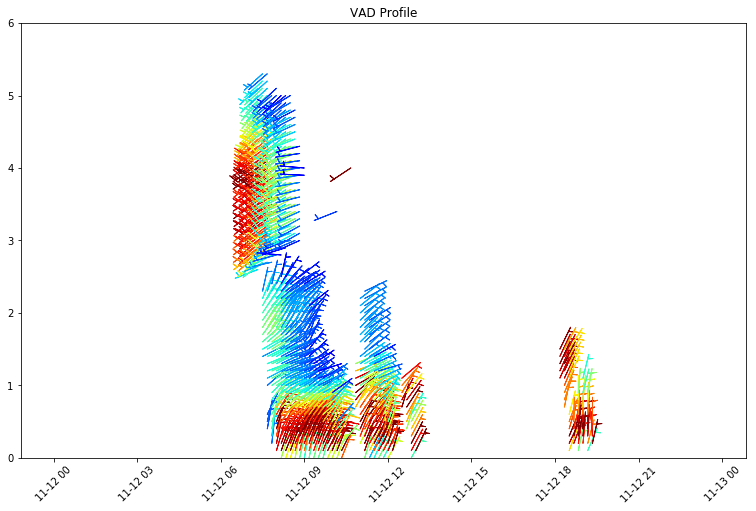

In [7]:
#fig = plt.figure(figsize=[13,8])
#ax = fig.add_subplot(111, )
ax = plt.figure(figsize=[13,8]).add_subplot(111)
for i in range(len(files)-1):
    Xq, Yq = np.meshgrid(t[i], z)
    cmap = plt.cm.jet
    img = plt.barbs(Xq[:,0], Yq[:,0], u[i], v[i], C[i], cmap=cmap, 
                   sizes=dict(emptybarb=0.0), rounding=True)
    
#plt.colorbar(img, cmap=cmap)
plt.title('VAD Profile')
#plt.xlim(datetime.datetime.strftime(datetime.datetime(2018,11,12,6,40,0), '%Y-%m-%dT%H:%M:%S'), 
#         datetime.datetime.strftime(datetime.datetime(2018,11,12,19,45,0), '%Y-%m-%dT%H:%M:%S'))
plt.xticks(rotation=45)
plt.ylim(0,6)
#plt.savefig('I6_corr_vel.png', dpi=300)
plt.show()
plt.close()